## ToDo:

- is the central discontinuity a statisitcal problem?
- is it an implementation problem?

## Statistics with Actual Implementation

40.37267080745342 %


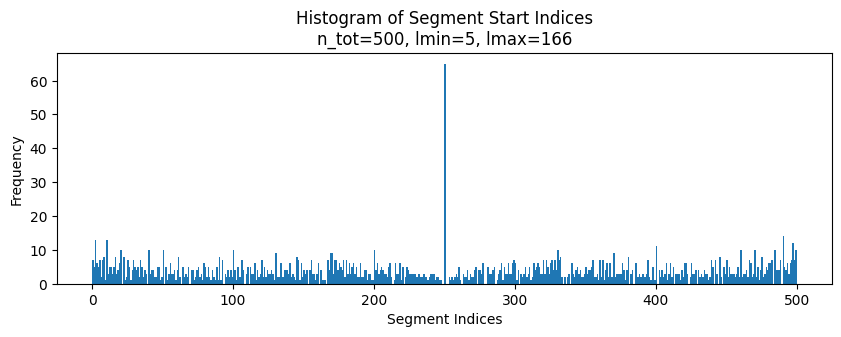

In [156]:
import numpy as np
import matplotlib.pyplot as plt

n_tot = 500
lmin = 5
lmax = n_tot // 3

n_l = lmax - lmin
counter = 0
sample = []
for length in range(lmin, lmax + 1):
    # Note: numba-compatible version of centered_segmentation (deprecated)
    n_seg = int(n_tot / length)  # number of segments
    rest = n_tot - n_seg * length  # uncovered points
    idx0 = int(rest / 2)  # first index of the first segment
    seg_idces = idx0 + length * np.arange(n_seg + 1)  # first index of each segment
    for idx in seg_idces:
        sample.append(int(idx) )#- (n_tot // 2))

    #print(f"Segment indices for length {length}: {seg_idces}")
    if (n_tot // 2) in seg_idces:
        counter += 1

print(f"{counter/n_l*100} %")
#print(sample)

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot=500, lmin={int(lmin)}, lmax={int(lmax)}")
plt.show()

## Statistics using My Own Formulas

In [39]:
def ix0(n_tot, length):
    return int((n_tot%length) / 2)

def ix0_center(n_tot, length):
    return int(n_tot/2)%length

def ix0_offset(n_tot, length, offset):
    return (int(n_tot/2) + offset) % length

lmin = 5

n_arr = np.arange(lmin*3, 200)
match_count = 0
total_count = 0
for n_tot in n_arr:
    #print(n_tot)
    lmax = n_tot // 3
    for length in range(lmin, lmax + 1):
        #print(length)
        if ix0(n_tot, length) == ix0_center(n_tot, length):
            match_count += 1
        total_count += 1

print(f"{match_count / total_count * 100} %")

40.83146455062964 %


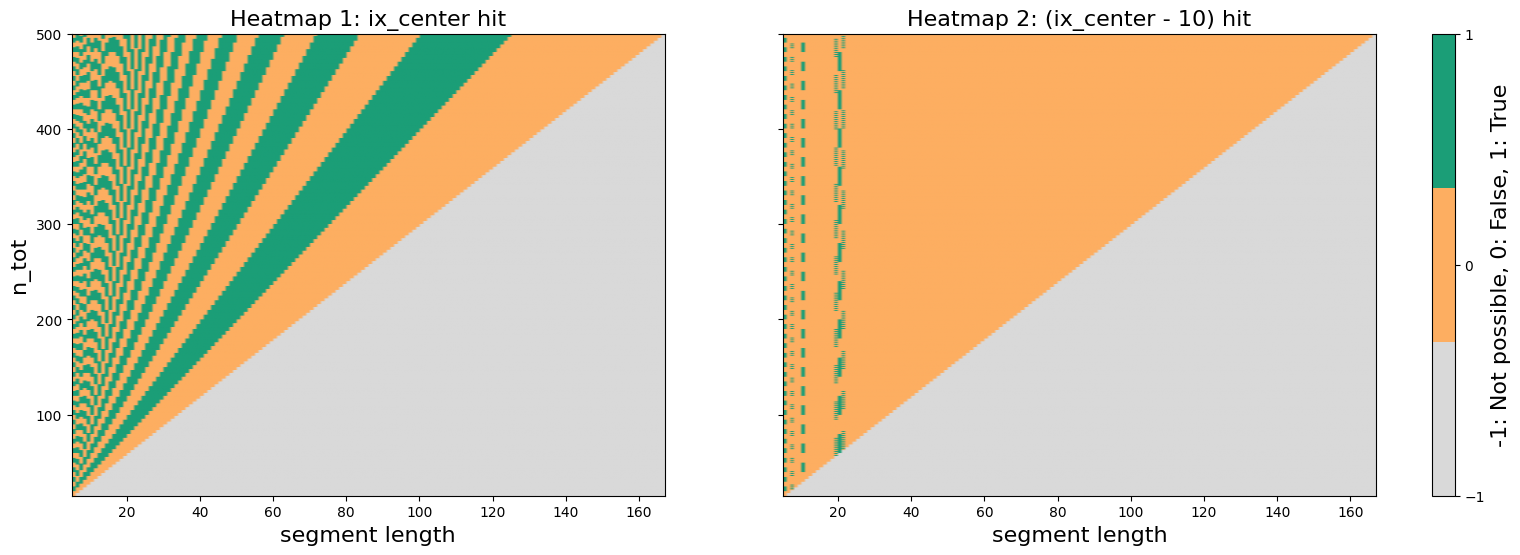

In [52]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

lmin = 5
n_arr = np.arange(lmin*3, 500)

# Prepare the heatmap array
heatmap1 = np.full((len(n_arr), n_arr[-1]//3 + 1-lmin), -1)  # -1: not possible, 0: red, 1: green
heatmap2 = np.full((len(n_arr), n_arr[-1]//3 + 1-lmin), -1)  # -1: not possible, 0: red, 1: green

for i, n_tot in enumerate(n_arr):
    lmax = n_tot // 3
    for length in range(lmin, lmax + 1):
        if ix0(n_tot, length) == (ix0_center(n_tot, length)-0):
            heatmap1[i, length-lmin] = 1  # green
        else:
            heatmap1[i, length-lmin] = 0  # red

        if ix0(n_tot, length) == (ix0_offset(n_tot, length, 10)):
            heatmap2[i, length-lmin] = 1  # green
        else:
            heatmap2[i, length-lmin] = 0  # red

# Create a custom colormap: -1 (black), 0 (red), 1 (green)
cmap = ListedColormap(
    ['#d9d9d9',  # light gray
     '#fdae61',  # soft orange
     '#1b9e77']  # teal/greenish-blue
     , [-1,0,1]
     )

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

im1 = axes[0].imshow(
    heatmap1,
    aspect='auto',
    cmap=cmap,
    origin='lower',
    extent=[lmin, heatmap1.shape[1] + lmin, n_arr[0], n_arr[-1] + 1],
    vmin=-1, vmax=1
)
axes[0].set_xlabel('segment length', fontsize=16)
axes[0].set_ylabel('n_tot', fontsize=16)
axes[0].set_title('Heatmap 1: ix_center hit', fontsize=16)

im2 = axes[1].imshow(
    heatmap2,
    aspect='auto',
    cmap=cmap,
    origin='lower',
    extent=[lmin, heatmap2.shape[1] + lmin, n_arr[0], n_arr[-1] + 1],
    vmin=-1, vmax=1
)
axes[1].set_xlabel('segment length', fontsize=16)
axes[1].set_title('Heatmap 2: (ix_center - 10) hit', fontsize=16)

# Create a single colorbar for both plots
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, ticks=[-1, 0, 1])
cbar.set_label('-1: Not possible, 0: False, 1: True', fontsize=16)

#plt.tight_layout()
plt.show()

## Finding better Segmentations

My first idea is to brute force the uniformness of the final gap probability distribution by shifting the starting index for every value of segment length so minimizie the un-uniformness. Hence, we need a measure which quantifies how uniform the current distribution is, so we can choose the one starting index with the least deviation.

Asking ChatGPT about a measure which is sensitive to outliers, it came up with the following suggestions. $u(i)$ represents the target distribution (here: uniform):

- Kullback–Leibler Divergence (KL divergence) from Uniform

$$ D_{KL}​(p∥u)=∑_i​p(i)log \left( \frac{p(i)}{u(i)} \right)​ $$

- Chi-Square Distance from Uniform

$$ χ^2=∑_i​ \frac{(p(i)−u(i))^2}{u(i)}​ $$

- Shannon-Entropy Deficit

$$ H(p)=−∑_i​p(i)logp(i) $$
$$ \rightarrow \text{Deficit: }  ΔH=log \left( n \right) − H(p) $$

- Gini Coefficient (Inequality of Probabilities)

$$ G =  \frac{∑_{i=1}^{n} ​∑_{j=1}^{n} ​∣p(i)−p(j)∣}{2n ∑_{i=1}^{n} ​p(i)}​ $$
    -> G=0 means uniform

- Outlier-Sensitive Max/Mean Ratio

$$ R = \frac{max_i ​p(i)}{mean(p(i))} $$

In [4]:
# measures for uniformity

import numpy as np

def homogeneity_measures(hist):
    """
    Compute several measures of homogeneity / uniformity for a probability distribution.
    
    Parameters
    ----------
    hist : array-like
        Histogram values (counts or probabilities). Will be normalized internally.
    
    Returns
    -------
    dict
        Dictionary of homogeneity measures.
    """
    hist = np.asarray(hist, dtype=float)
    if hist.sum() <= 0:
        raise ValueError("Histogram must have positive total count.")
        
    # Normalize to probability distribution
    p = hist / hist.sum()
    n = len(p)
    uniform = np.ones(n) / n
    
    # --- 1. KL Divergence from uniform ---
    # Avoid log(0) by masking zeros
    mask = p > 0
    kl_div = np.sum(p[mask] * np.log(p[mask] / uniform[mask]))
    
    # --- 2. Chi-Square distance from uniform ---
    chi2 = np.sum((p - uniform) ** 2 / uniform)
    
    # --- 3. Entropy deficit ---
    entropy = -np.sum(p[mask] * np.log(p[mask]))
    max_entropy = np.log(n)
    entropy_deficit = max_entropy - entropy
    
    # --- 4. Gini coefficient ---
    # Equivalent to inequality measure of p
    diff_sum = np.sum(np.abs(p[:, None] - p[None, :]))
    gini = diff_sum / (2 * n * p.sum())
    
    # --- 5. Max/mean ratio ---
    mean_prob = np.mean(p)
    max_mean_ratio = np.max(p) / mean_prob
    
    return {
        "KL_divergence": kl_div,
        "Chi2_distance": chi2,
        "Entropy_deficit": entropy_deficit,
        "Gini_coefficient": gini,
        "Max_mean_ratio": max_mean_ratio,
    }


# Perfectly uniform histogram of 10 bins
uniform_hist = np.ones(10)
print("Uniform histogram:", homogeneity_measures(uniform_hist))

# Histogram with one big outlier
outlier_hist = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 50])
print("\nOutlier histogram:", homogeneity_measures(outlier_hist))


Uniform histogram: {'KL_divergence': np.float64(0.0), 'Chi2_distance': np.float64(0.0), 'Entropy_deficit': np.float64(4.440892098500626e-16), 'Gini_coefficient': np.float64(0.0), 'Max_mean_ratio': np.float64(1.0)}

Outlier histogram: {'KL_divergence': np.float64(1.540321382502009), 'Chi2_distance': np.float64(6.207698937087043), 'Entropy_deficit': np.float64(1.5403213825020095), 'Gini_coefficient': np.float64(0.7474576271186442), 'Max_mean_ratio': np.float64(8.47457627118644)}


In [5]:
# function to create histogram
import numpy as np

def agg_idx0(n_tot, lmin=5, lmax=None):

    if lmax is None:
        lmax = n_tot // 3

    sample = []
    for length in range(lmin, lmax + 1):
        n_seg = int(n_tot / length)                         # number of segments
        rest = n_tot - n_seg * length                       # uncovered points
        idx0 = int(rest / 2)                                # first index of the first segment
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        for idx in seg_idces:
            sample.append(int(idx))

    return sample

In [6]:
n_tot = 500
sample = agg_idx0(n_tot)

# make a histogram-array
hist, bin_edges = np.histogram(sample, bins=n_tot)

homogeneity_measures(hist)

{'KL_divergence': np.float64(0.29133077103036126),
 'Chi2_distance': np.float64(0.9343096553069403),
 'Entropy_deficit': np.float64(0.29133077103036165),
 'Gini_coefficient': np.float64(0.3802144743792921),
 'Max_mean_ratio': np.float64(17.16851558372953)}

In [ ]:
import numpy as np

def KL(hist):
    hist = np.asarray(hist, dtype=float)
    
    # Normalize to probability distribution
    p = hist / hist.sum()
    n = len(p)
    uniform = np.ones(n) / n

    # Avoid log(0) by masking zeros
    mask = p > 0
    kl_div = np.sum(p[mask] * np.log(p[mask] / uniform[mask]))

    return kl_div


def chi2(hist):
    hist = np.asarray(hist, dtype=float)
    
    # Normalize to probability distribution
    p = hist / hist.sum()
    n = len(p)
    uniform = np.ones(n) / n
    
    return np.sum((p - uniform) ** 2 / uniform)

def entropy(hist):
    hist = np.asarray(hist, dtype=float)
    
    # Normalize to probability distribution
    p = hist / hist.sum()
    n = len(p)

    # --- Entropy deficit ---
    # Avoid log(0) by masking zeros
    mask = p > 0
    entropy = -np.sum(p[mask] * np.log(p[mask]))
    max_entropy = np.log(n)
    entropy_deficit = max_entropy - entropy

    return entropy_deficit

def max_mean(hist):
    hist = np.asarray(hist, dtype=float)

    # Normalize to probability distribution
    p = hist / hist.sum()

    # --- Max/mean ratio ---
    mean_prob = np.mean(p)
    max_mean_ratio = np.max(p) / mean_prob

    return max_mean_ratio

In [37]:
# segmentation with adapting starting index
import numpy as np

def adapting_idx0(n_tot,
                  ufunc,
                  lmin=5,
                  lmax=None,
                  verbose=False):
    """
    This function computes the maximum possible number of segments
    and how many points will be uncovered. Within this range of uncovered
    points, the function runs through all possible starting indices and finds
    the one which leads to the most uniform distribution of gap indices.
    """

    if lmax is None:
        lmax = n_tot // 3

    sample = []
    for length in range(lmin, lmax + 1):
        n_seg = int(n_tot / length)                         # number of segments
        rest = n_tot - n_seg * length                       # uncovered points
        if verbose: print(f"Length: {length}, Segments: {n_seg}, Uncovered: {rest}")
        if rest != 0:
            q_arr = []
            for idx0 in range(rest + 1):                     # try all possible starting indices for the first segment
                sample_cp = sample.copy()
                seg_idces = idx0 + length * np.arange(n_seg + 1)
                for idx in seg_idces:
                    sample_cp.append(int(idx))
                q_arr.append(ufunc(sample_cp))
            
            if verbose: print(q_arr)
            idx0 = np.argmin(q_arr)  # choose the starting index which leads to the most uniform distribution
        else:
            idx0 = 0
        if verbose: print(f"Minimizing Starting Index: {idx0}")
        seg_idces = idx0 + length * np.arange(n_seg + 1)    # first index of each segment
        for idx in seg_idces:
            sample.append(int(idx))

    return sample


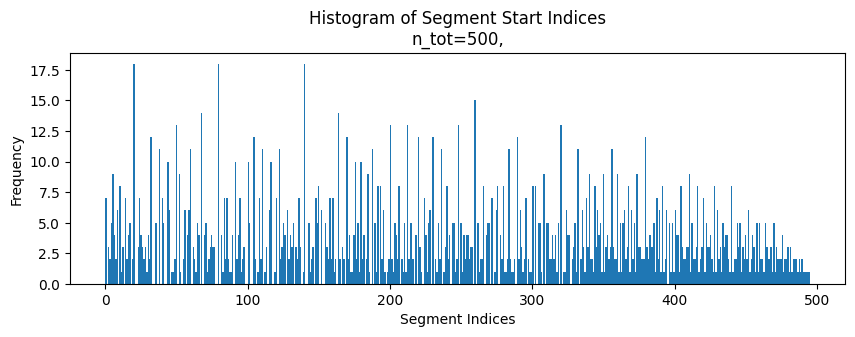

In [38]:
import matplotlib.pyplot as plt

n_tot = 500
sample = adapting_idx0(n_tot,
                       KL,
                       verbose=False)
# filter out n_tot
sample = [s for s in sample if s < n_tot]

# histogram
plt.figure(figsize=(10, 3))
plt.hist(sample, bins=n_tot)
plt.xlabel("Segment Indices")
plt.ylabel("Frequency")
plt.title(f"Histogram of Segment Start Indices\nn_tot=500,")
plt.show()